In [1]:
import os, glob
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import pickle
import csv

# Collect trial info

In [2]:
# Make sure to update the followings to the correct value
units_input = 124
units_output_upper = 128
units_output_lower = 128 # linear + relu

In [3]:
dir_results = '../results'
flist       = glob.glob(f'{dir_results}/*/*/*.csv')
RESULTS={}
for k, kf in enumerate(flist): # kf = f_csv
    RESULTS[k] = {}
    RESULTS[k]['lot'] = kf.split('/')[-3]
    RESULTS[k]['trial'] = kf.split('/')[-2]
    
    # collect csv data
    # : val loss
    work = pd.read_csv(kf)['val_loss']
    if len(work)!=12:  # -4 is for non-unit hp
        # cheange for unit_11 exist...
        del RESULTS[k] 
        continue
    RESULTS[k]['val_loss'] = np.array(work)
    RESULTS[k]['min_val_loss'] = work.min()
    RESULTS[k]['min_val_loss_epoch'] = work.argmin()+1 # 0-based index
        
    # collect json data
    # : num_layers activation  batch_size optimizer units_{klayer}
    f_json  = f"../results/{RESULTS[k]['lot']}/{RESULTS[k]['trial']}/trial.json"
    with open(f_json) as f:
        work = json.load(f)
    for khp in ['activation','batch_size','num_layers','optimizer']:
        RESULTS[k][khp] = work['hyperparameters']['values'][khp]

    # check the sanity of trial.json (for unit)
    
    # if False: #len(work['hyperparameters']['values'])-4 != 12:
    if f"units_{RESULTS[k]['num_layers']-1}" not in work['hyperparameters']['values'].keys():
        # print('ERROR (%s, %s)'%(RESULTS[k]['lot'], RESULTS[k]['trial']))
        del RESULTS[k]
        continue
    else:
        units = np.array( [work['hyperparameters']['values']['units_%d'%(k)] 
                           for k in range(RESULTS[k]['num_layers'])] )
        RESULTS[k]['units'] = units
    

    # Add Num_Params
    layers = np.array([units_input, *units, units_output_upper, units_output_lower])
    RESULTS[k]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])
    
RESULTS_PD = pd.DataFrame(RESULTS).transpose()

In [4]:
# save RESULTS_PD to csv after sorting by val_loss
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
RESULTS_PD.to_csv('step1_results.csv')

7983


# Visualization (HP vs. min val loss)

top 10% (blue) and top 1% (orange) models

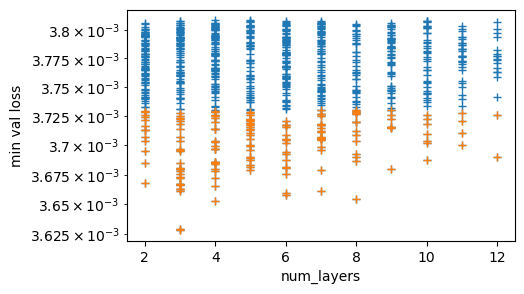

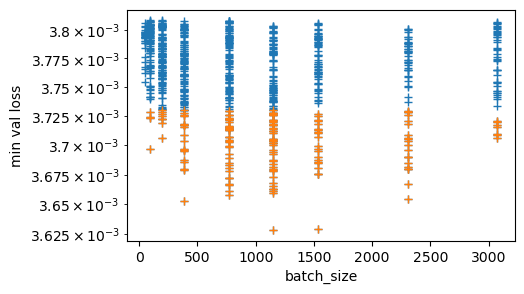

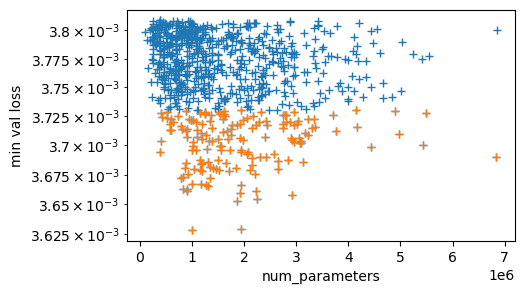

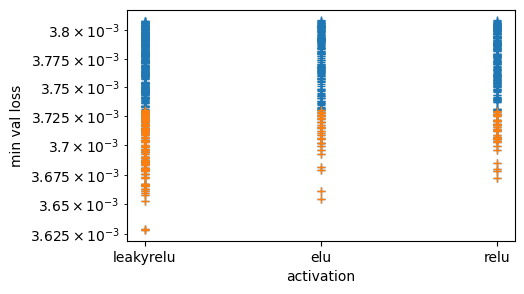

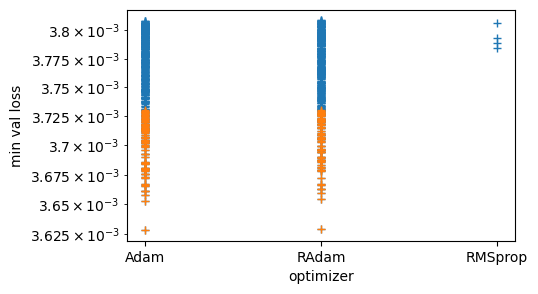

In [5]:
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_3p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.03))].iloc[-1] # top 3%
th_loss_2p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.02))].iloc[-1] # top 2%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_10p, th_loss_2p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

top 99% (blue) and top 1% (orange) models

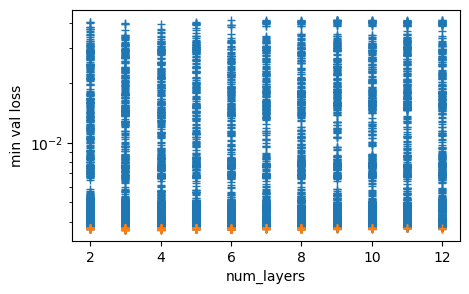

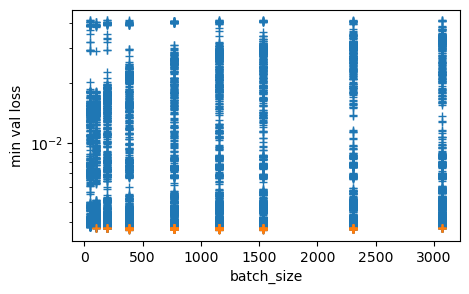

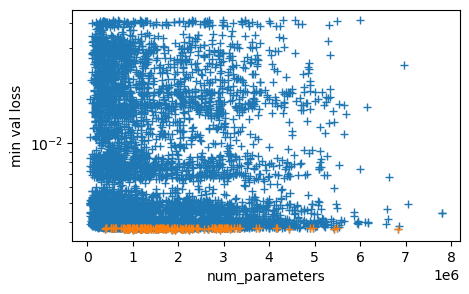

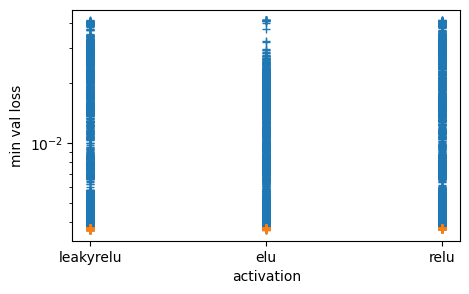

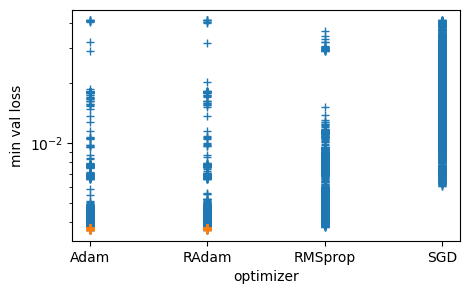

In [6]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.10))].iloc[-1] # top 10%
th_loss_3p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.03))].iloc[-1] # top 3%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 1%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_99p, th_loss_2p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

num_params vs. num_layers

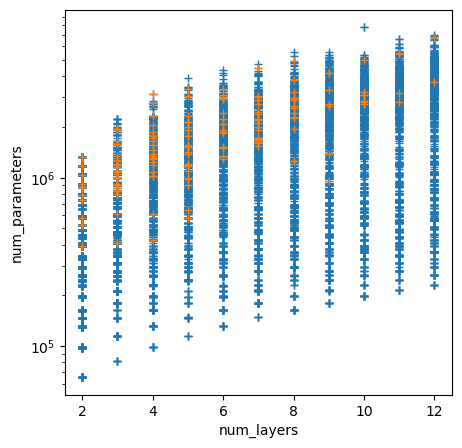

In [7]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%

kvar_y='num_parameters'
kvar_x='num_layers'
fig, ax = plt.subplots()
for kth in [th_loss_99p, th_loss_2p]:
    ploty = RESULTS_PD['min_val_loss']
    indy = ploty<kth
    ploty = RESULTS_PD[kvar_y]
    ploty = ploty[indy]
    plotx = RESULTS_PD[kvar_x]
    plotx = plotx[indy]
    ax.plot(plotx,ploty, ls='none', marker='+')
ax.set_yscale('log')
ax.set_xlabel(kvar_x)
ax.set_ylabel(kvar_y)
fig.set_size_inches(5,5)

# Pick the best models

In [8]:
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
print(len(RESULTS_PD)*0.02)

7983
159.66


In [8]:
# Note the mistake here. [:131] should have been [:160]
TOP160 = RESULTS_PD.iloc[:131]
with open('top160.lot.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160['lot'].values ])
with open('top160.trial.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160['trial'].values ])
TOP160

,lot,trial,val_loss,min_val_loss,min_val_loss_epoch,activation,batch_size,num_layers,optimizer,units,num_parameters
10470,lot-126,trial_0035,"[0.0043797898106276, 0.0041720611043274, 0.004...",0.003628,12,leakyrelu,1152,3,Adam,"[256, 640, 1024]",1000576
5740,lot-42,trial_0040,"[0.011175537481904, 0.0079524759203195, 0.0078...",0.003629,11,leakyrelu,1536,3,RAdam,"[768, 1024, 896]",1933184
10714,lot-141,trial_0021,"[0.0043350234627723, 0.0042862547561526, 0.003...",0.003653,12,leakyrelu,384,4,Adam,"[256, 896, 896, 768]",1869824
8724,lot-123,trial_0047,"[0.0050680353306233, 0.0046697533689439, 0.004...",0.003654,12,elu,2304,8,RAdam,"[768, 640, 512, 256, 896, 640, 384, 256]",2246144
9,lot-139,trial_0023,"[0.0044564204290509, 0.0042644557543098, 0.004...",0.003658,12,leakyrelu,768,6,Adam,"[256, 896, 768, 896, 640, 896]",2919936
...,...,...,...,...,...,...,...,...,...,...,...
6139,lot-164,trial_0022,"[0.0046914229169487, 0.0045681213960051, 0.004...",0.003722,8,elu,768,9,Adam,"[128, 256, 512, 256, 768, 128, 384, 512, 128]",953088
10439,lot-126,trial_0025,"[0.0044608796015381, 0.0039578187279403, 0.004...",0.003722,12,leakyrelu,768,10,RAdam,"[640, 768, 896, 384, 768, 640, 512, 256, 896, ...",3231232
6713,lot-92,trial_0044,"[0.0040288371965289, 0.0039752558805048, 0.003...",0.003723,12,leakyrelu,192,3,RAdam,"[512, 640, 256]",605824
11078,lot-36,trial_0027,"[0.0040209209546446, 0.0038909101858735, 0.003...",0.003723,12,leakyrelu,192,5,Adam,"[896, 896, 640, 1024, 1024]",3343488


In [9]:
TOP160_p2 = RESULTS_PD.iloc[131:160]
with open('top160_p2.lot.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160_p2['lot'].values ])
with open('top160_p2.trial.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160_p2['trial'].values ])
TOP160_p2

,lot,trial,val_loss,min_val_loss,min_val_loss_epoch,activation,batch_size,num_layers,optimizer,units,num_parameters
7351,lot-111,trial_0025,"[0.0048291981220245, 0.0046287728473544, 0.004...",0.003723,12,elu,768,4,RAdam,"[640, 640, 1024, 768]",2048768
315,lot-154,trial_0055,"[0.0043608816340565, 0.0043697645887732, 0.004...",0.003724,12,leakyrelu,96,2,Adam,"[384, 896]",524288
1993,lot-47,trial_0038,"[0.0043926304206252, 0.0043524862267076, 0.004...",0.003725,12,leakyrelu,192,4,Adam,"[1024, 128, 128, 512]",423936
7880,lot-91,trial_0026,"[0.0044144452549517, 0.0042020021937787, 0.004...",0.003725,8,leakyrelu,1536,3,Adam,"[384, 1024, 1024]",1639552
3473,lot-169,trial_0030,"[0.0041824174113571, 0.0040142713114619, 0.003...",0.003725,11,elu,384,7,Adam,"[1024, 896, 384, 384, 128, 384, 1024]",2179456
6317,lot-106,trial_0026,"[0.0044049685820937, 0.0042704488150775, 0.004...",0.003726,12,relu,768,2,RAdam,"[512, 1024]",737024
7046,lot-119,trial_0051,"[0.0049484116025269, 0.0046650222502648, 0.004...",0.003726,12,elu,768,12,RAdam,"[512, 384, 640, 768, 768, 128, 256, 1024, 640,...",3707648
9591,lot-172,trial_0050,"[0.0053302636370062, 0.0041090426966547, 0.003...",0.003726,12,relu,1152,4,Adam,"[896, 768, 1024, 1024]",2785664
10633,lot-162,trial_0046,"[0.0049598924815654, 0.0047555328346788, 0.004...",0.003726,12,elu,2304,9,RAdam,"[384, 640, 896, 640, 640, 896, 128, 128, 640]",2739840
1844,lot-27,trial_0032,"[0.0045010312460362, 0.0039354553446173, 0.004...",0.003726,12,leakyrelu,384,5,RAdam,"[896, 512, 768, 256, 512]",1375872


In [ ]:
!ls